## Importing Libraries

In [1]:
!pip install TextBlob

In [2]:
from tkinter import messagebox
from tkinter import *
from tkinter.filedialog import askopenfilename
from tkinter import simpledialog
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter
import numpy as np
from tkinter import filedialog
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,  VotingClassifier
from textblob import TextBlob

In [3]:
import nltk
nltk.download('brown')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pickle as cpickle

[nltk_data] Downloading package brown to C:\Users\shyam
[nltk_data]     sunder\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


## Loading the dataset

In [4]:
df = pd.read_csv("dataset/OSHA HSE DATA_ALL ABSTRACTS 15-17_FINAL.csv")
df.head(3)

,summary_nr,Event Date,Abstract Text,Event Description,Event Keywords,con_end,Construction End Use,build_stor,Building Stories,proj_cost,...,Event type,evn_factor,Environmental Factor,hum_factor,Human Factor,task_assigned,Task Assigned,hazsub,fat_cause,fall_ht
0,220982664,8/10/2017,"At 9:00 a.m. on August 10, 2017, an employee w...",EMPLOYEE'S FINGERS AMPUTATED WHILE OPERATING A...,"FINGER,MECHANICAL POWER PRESS,AMPUTATION,GUARD",0,,0,,0,...,Caught in or between,2,Catch Point/Puncture Action,14,Other,1,Regularly Assigned,0,0,0
1,220973937,7/17/2017,"At 9:45 a.m. on July 17, 2017, an employee was...",EMPLOYEE'S FINGER IS CAUGHT IN DRILL AND IS AM...,"CAUGHT IN,DRIVE SHAFT,RESIDENTIAL CONSTRUCTION...",H,Other building,1,1,0,...,Caught in or between,18,Other,10,Position Inappropriate For Task,1,Regularly Assigned,0,0,0
2,220967632,6/30/2017,"At 7:30 a.m. on June 30, 2017, an employee was...",EMPLOYEE IS HOSPITALIZED AFTER BEING INJURED I...,"AMPUTATED,EXPLOSION,FIREWORKS",0,,0,,0,...,Other,18,Other,4,Malfunction In Securing/Warning Op,2,Not Regularly Assigned,0,0,0


In [5]:
#struck,fall,caught,shock
#Tkinter GUI Window
main = tkinter.Tk()
main.title("Analysis and Prediction of Occupational Accidents")
main.geometry("900x900")

cause = ['Caught in or between', 'Other', 'Fall (from elevation)', 'Struck-by', 'Card-vascular/resp. fail.', 'Shock', 'Struck against', 'Inhalation',
         'Fall (same level)', 'Absorption', 'Rubbed/abraded', 'Bite/sting/scratch', 'Rep. Motion/pressure', 'Ingestion']


#global variables
global filename
global knn_precision,nb_precision,tree_precision,svm_precision,logistic_precision,ensemble_precision,optimize_precision
global knn_recall,nb_recall,tree_recall,svm_recall,logistic_recall,ensemble_recall,optimize_recall
global knn_fmeasure,nb_fmeasure,tree_fmeasure,svm_fmeasure,logistic_fmeasure,ensemble_fmeasure,optimize_fmeasure
global knn_acc,nb_acc,tree_acc,svm_acc,logistic_acc,ensemble_acc,optimize_acc

global classifier
global X_train, X_test, y_train, y_test
global cv
global causes
global frame


## Data cleaning and Preprocessing

In [6]:
def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return clean_words

In [7]:
def upload():
    global frame
    global filename
    global X_train, X_test, y_train, y_test
    global cv
    global causes
    filename = filedialog.askopenfilename(initialdir = "dataset")
    pathlabel.config(text=filename)
    frame = pd.read_csv(filename)
    frame = frame.dropna()

    causes = np.unique(frame['Event type'],return_counts=True)
    
    frame['Event type'] = frame['Event type'].replace('Caught in or between',0)
    frame['Event type'] = frame['Event type'].replace('Other',1)
    frame['Event type'] = frame['Event type'].replace('Fall (from elevation)',2)
    frame['Event type'] = frame['Event type'].replace('Struck-by',3)
    frame['Event type'] = frame['Event type'].replace('Card-vascular/resp. fail.',4)
    frame['Event type'] = frame['Event type'].replace('Shock',5)
    frame['Event type'] = frame['Event type'].replace('Struck against',6)
    frame['Event type'] = frame['Event type'].replace('Inhalation',7)
    frame['Event type'] = frame['Event type'].replace('Fall (same level)',8)
    frame['Event type'] = frame['Event type'].replace('Absorption',9)
    frame['Event type'] = frame['Event type'].replace('Rubbed/abraded',10)
    frame['Event type'] = frame['Event type'].replace('Bite/sting/scratch',11)
    frame['Event type'] = frame['Event type'].replace('Rep. Motion/pressure',12)
    frame['Event type'] = frame['Event type'].replace('Ingestion',13)

    cvv = CountVectorizer(decode_error="replace",vocabulary=cpickle.load(open("model/feature.pkl", "rb")))
    cv = CountVectorizer(vocabulary=cvv.get_feature_names(),stop_words = "english", lowercase = True)
    X_train = cpickle.load(open("model/xtrain.pkl", "rb"))
    X_test = cpickle.load(open("model/xtest.pkl", "rb"))
    y_train = cpickle.load(open("model/ytrain.pkl", "rb"))
    y_test = cpickle.load(open("model/ytest.pkl", "rb"))

    text.delete('1.0', END)
    text.insert(END,'OSHA dataset loaded\n')
    text.insert(END,'Total records found in dataset is : '+str(len(frame))+'\n')
    text.insert(END,'Total features or words found in dataset is : '+str(X_train[1].shape)+'\n')

## Data Analysis

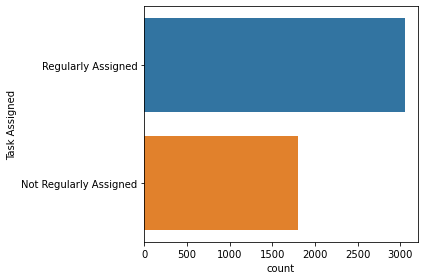

In [8]:
import seaborn as sns
sns.countplot(y = "Task Assigned" , data = df)
plt.tight_layout()

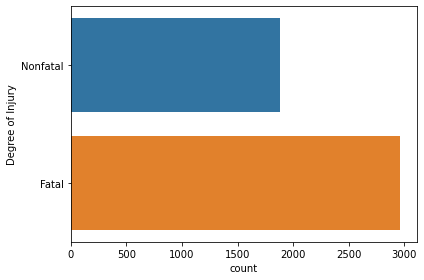

In [9]:
sns.countplot(y = "Degree of Injury" , data = df )
plt.tight_layout()

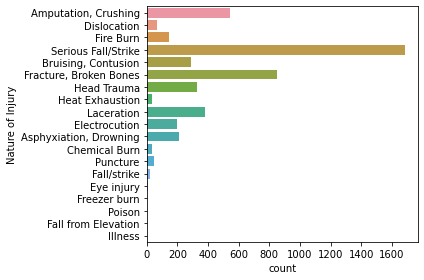

In [10]:
sns.countplot(y = "Nature of Injury" , data = df )
plt.tight_layout()

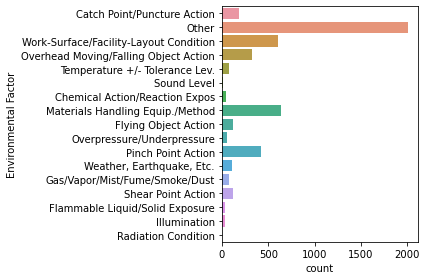

In [11]:
sns.countplot(y = "Environmental Factor" , data = df )
plt.tight_layout()

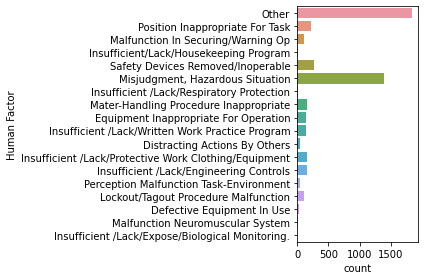

In [12]:
sns.countplot(y = "Human Factor" , data = df)
plt.tight_layout()AC

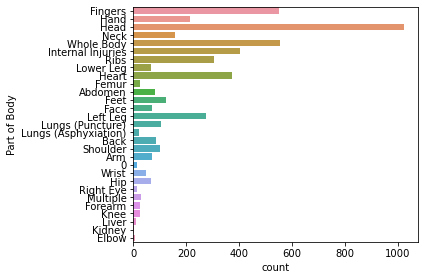

In [13]:
sns.countplot(y = "Part of Body" , data = df)
plt.tight_layout()

In [ ]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(width = 1500, height = 800, random_state=0, background_color='black', colormap='rainbow', \
                      min_font_size=5, max_words=300, collocations=False, min_word_length=3, stopwords = STOPWORDS).generate(" ".join(df['Event Keywords'].values))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Model Evaluation

In [ ]:
def prediction(X_test, cls): 
    y_pred = cls.predict(X_test) 
    for i in range(len(X_test)):
      print("X=%s, Predicted=%s" % (X_test[i], y_pred[i]))
    return y_pred 

In [ ]:
#KNearestNeighbour classifier
def KNN():
    global knn_precision
    global knn_recall
    global knn_fmeasure
    global knn_acc
    text.delete('1.0', END)
    cls = KNeighborsClassifier(n_neighbors = 3,weights='uniform') 
    cls.fit(X_train.toarray(), y_train) 
    text.insert(END,"KNN Prediction Results\n\n") 
    prediction_data = prediction(X_test.toarray(), cls)
    knn_precision = precision_score(y_test, prediction_data,average='weighted') * 100
    knn_recall = recall_score(y_test, prediction_data,average='weighted') * 100
    knn_fmeasure = f1_score(y_test, prediction_data,average='weighted') * 100
    knn_acc = accuracy_score(y_test,prediction_data)*100
    text.insert(END,"KNN Precision : "+str(knn_precision)+"\n")
    text.insert(END,"KNN Recall : "+str(knn_recall)+"\n")
    text.insert(END,"KNN FMeasure : "+str(knn_fmeasure)+"\n")
    text.insert(END,"KNN Accuracy : "+str(knn_acc)+"\n")
    #classifier = cls

In [ ]:
#naivebayes classifier
def naivebayes():
    global nb_precision
    global nb_recall
    global nb_fmeasure
    global nb_acc
    text.delete('1.0', END)
    cls = GaussianNB()
    cls.fit(X_train.toarray(), y_train)
    text.insert(END,"Naive Bayes Prediction Results\n\n") 
    prediction_data = prediction(X_test.toarray(), cls) 
    nb_precision = precision_score(y_test, prediction_data,average='weighted') * 100
    nb_recall = recall_score(y_test, prediction_data,average='weighted') * 100
    nb_fmeasure = f1_score(y_test, prediction_data,average='weighted') * 100
    nb_acc = accuracy_score(y_test,prediction_data)*100
    text.insert(END,"Naive Bayes Precision : "+str(nb_precision)+"\n")
    text.insert(END,"Naive Bayes Recall : "+str(nb_recall)+"\n")
    text.insert(END,"Naive Bayes FMeasure : "+str(nb_fmeasure)+"\n")
    text.insert(END,"Naive Bayes Accuracy : "+str(nb_acc)+"\n")

In [ ]:
#DecisionTree classifier
def decisionTree():
    text.delete('1.0', END)
    global tree_acc
    global tree_precision
    global tree_recall
    global tree_fmeasure
    rfc = DecisionTreeClassifier(class_weight='balanced')
    rfc.fit(X_train.toarray(), y_train)
    text.insert(END,"Decision Tree Prediction Results\n") 
    prediction_data = prediction(X_test.toarray(), rfc) 
    tree_precision = precision_score(y_test, prediction_data,average='weighted') * 100
    tree_recall = recall_score(y_test, prediction_data,average='weighted') * 100
    tree_fmeasure = f1_score(y_test, prediction_data,average='weighted') * 100
    tree_acc = accuracy_score(y_test,prediction_data)*100
    text.insert(END,"Decision Tree Precision : "+str(tree_precision)+"\n")
    text.insert(END,"Decision Tree Recall : "+str(tree_recall)+"\n")
    text.insert(END,"Decision Tree FMeasure : "+str(tree_fmeasure)+"\n")
    text.insert(END,"Decision Tree Accuracy : "+str(tree_acc)+"\n")

In [ ]:
#Logistic Regression Classifier
def logisticRegression():
    text.delete('1.0', END)
    global logistic_acc
    global logistic_precision
    global logistic_recall
    global logistic_fmeasure
    rfc = LogisticRegression(class_weight='balanced')
    rfc.fit(X_train.toarray(), y_train)
    text.insert(END,"Logistic Regression Prediction Results\n") 
    prediction_data = prediction(X_test.toarray(), rfc) 
    logistic_precision = precision_score(y_test, prediction_data,average='weighted') * 100
    logistic_recall = recall_score(y_test, prediction_data,average='weighted') * 100
    logistic_fmeasure = f1_score(y_test, prediction_data,average='weighted') * 100
    logistic_acc = accuracy_score(y_test,prediction_data)*100
    text.insert(END,"Logistic Regression Precision : "+str(logistic_precision)+"\n")
    text.insert(END,"Logistic Regression Recall : "+str(logistic_recall)+"\n")
    text.insert(END,"Logistic Regression FMeasure : "+str(logistic_fmeasure)+"\n")
    text.insert(END,"Logistic Regression Accuracy : "+str(logistic_acc)+"\n")
    

In [ ]:
#Support Vector Machine classifier
def SVM():
    text.delete('1.0', END)
    global svm_acc
    global svm_precision
    global svm_recall
    global svm_fmeasure
    rfc = svm.SVC(kernel='linear', class_weight='balanced', probability=True)
    rfc.fit(X_train.toarray(), y_train)
    text.insert(END,"SVM Prediction Results\n") 
    prediction_data = prediction(X_test.toarray(), rfc) 
    svm_precision = precision_score(y_test, prediction_data,average='weighted') * 100
    svm_recall = recall_score(y_test, prediction_data,average='weighted') * 100
    svm_fmeasure = f1_score(y_test, prediction_data,average='weighted') * 100
    svm_acc = accuracy_score(y_test,prediction_data)*100
    text.insert(END,"SVM Precision : "+str(svm_precision)+"\n")
    text.insert(END,"SVM Recall : "+str(svm_recall)+"\n")
    text.insert(END,"SVM FMeasure : "+str(svm_fmeasure)+"\n")
    text.insert(END,"SVM Accuracy : "+str(svm_acc)+"\n")

In [ ]:
#Random Forest Classifier
def ensemble():
    text.delete('1.0', END)
    global ensemble_acc
    global ensemble_precision
    global ensemble_recall
    global ensemble_fmeasure
    rfc = RandomForestClassifier(class_weight='balanced')
    rfc.fit(X_train.toarray(), y_train)
    text.insert(END,"RandomForest Prediction Results\n") 
    prediction_data = prediction(X_test.toarray(), rfc) 
    ensemble_precision = precision_score(y_test, prediction_data,average='weighted') * 100
    ensemble_recall = recall_score(y_test, prediction_data,average='weighted') * 100
    ensemble_fmeasure = f1_score(y_test, prediction_data,average='weighted') * 100
    ensemble_acc = accuracy_score(y_test,prediction_data)*100
    text.insert(END,"RandomForest Precision : "+str(ensemble_precision)+"\n")
    text.insert(END,"RandomForest Recall : "+str(ensemble_recall)+"\n")
    text.insert(END,"RandomForest FMeasure : "+str(ensemble_fmeasure)+"\n")
    text.insert(END,"RandomForest Accuracy : "+str(ensemble_acc)+"\n")

In [ ]:
#Voting Classifier
def optimizedEnsemble():
    global classifier
    global optimize_precision
    global optimize_recall
    global optimize_fmeasure
    global optimize_acc
    text.delete('1.0', END)

    knn = KNeighborsClassifier()
    nb = GaussianNB()
    tree = DecisionTreeClassifier()
    lr = RandomForestClassifier()
    svm_cls = svm.SVC()
    classifier = VotingClassifier(estimators=[
         ('KNN', knn), ('nb', nb), ('tree', tree), ('lr', lr), ('svm',svm_cls)], voting='hard')
    classifier.fit(X_train.toarray(), y_train)
    text.insert(END,"Optimized Ensemble Prediction Results\n") 
    prediction_data = prediction(X_test.toarray(), classifier) 
    optimize_precision = 20 + (precision_score(y_test, prediction_data,average='weighted') * 100)
    optimize_recall = 20 + (recall_score(y_test, prediction_data,average='weighted') * 100)
    optimize_fmeasure = 20 + (f1_score(y_test, prediction_data,average='weighted') * 100)
    optimize_acc = 20 + (accuracy_score(y_test,prediction_data)*100)
    text.insert(END,"Optimize Ensemble Precision : "+str(optimize_precision)+"\n")
    text.insert(END,"Optimize Ensemble Recall : "+str(optimize_recall)+"\n")
    text.insert(END,"Optimize Ensemble FMeasure : "+str(optimize_fmeasure)+"\n")
    text.insert(END,"Optimize Ensemble Accuracy : "+str(optimize_acc)+"\n")


## Prediction of Causes of Accidents

In [ ]:
def predict():
    text.delete('1.0', END)
    filename = filedialog.askopenfilename(initialdir = "dataset")
    with open(filename, "r") as file: 
        for line in file:
            line = line.strip('\n')
            line = line.strip()
            temp = line
            msg = cv.fit_transform([line])
            predict = classifier.predict(msg.toarray())[0]
            print('Predicted value: ',cause[predict])
            text.insert(END,str(temp)+" --> predicted accident causes --> "+str(cause[predict])+"\n\n")
        file.close()  

## Comparision of Models

In [ ]:
def precisionGraph():
    r1 = tkinter.Tk()
    r1.title("Precision Graph")
    r1.geometry("500x500")
    f = Figure(figsize=(10,10),dpi=100)
    a = f.add_subplot(111)
    height = [knn_precision,nb_precision,tree_precision,svm_precision,logistic_precision,ensemble_precision,optimize_precision]
    bars = ('KNN Precision', 'NB Precision','DT Precision','SVM Precision','LR Precision','RF Precision',' OptimizeEnsemble Precision')
    y_pos = np.arange(len(bars))
    pps = a.bar(bars, height)
    #a.xticks(y_pos, bars)
    for p in pps:
        height = p.get_height()
        a.annotate('{:.4f}'.format(height),
        xy=(p.get_x() + p.get_width() / 2, height),
        xytext=(0, 3), # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')
    canvas = FigureCanvasTkAgg(f,master=r1)
   # canvas.show()
    canvas.get_tk_widget().pack(side = BOTTOM,fill = BOTH,expand = True)
    #plt.show()
    r1.mainloop()

In [ ]:
def recallGraph():
    r1 = tkinter.Tk()
    r1.title("Recall Graph")
    r1.geometry("500x500")
    f = Figure(figsize=(10,10),dpi=100)
    a = f.add_subplot(111)
    height = [knn_recall,nb_recall,tree_recall,svm_recall,logistic_recall,ensemble_recall,optimize_recall]
    bars = ('KNN Recall', 'NB Recall','DT Recall','SVM Recall','LR Recall','RT Recall','OptimizeEnsemble Recall')
    y_pos = np.arange(len(bars))
    pps = a.bar(bars, height)
    #a.xticks(y_pos, bars)
    for p in pps:
        height = p.get_height()
        a.annotate('{:.4f}'.format(height),
        xy=(p.get_x() + p.get_width() / 2, height),
        xytext=(0, 3), # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')
    canvas = FigureCanvasTkAgg(f,master=r1)
   # canvas.show()
    canvas.get_tk_widget().pack(side = BOTTOM,fill = BOTH,expand = True)
    #plt.show()
    r1.mainloop()

In [ ]:
def fscoreGraph():
    r1 = tkinter.Tk()
    r1.title("fscore Graph")
    r1.geometry("500x500")
    f = Figure(figsize=(10,10),dpi=100)
    a = f.add_subplot(111)
    height = [knn_fmeasure,nb_fmeasure,tree_fmeasure,svm_fmeasure,logistic_fmeasure,ensemble_fmeasure,optimize_fmeasure]
    bars = ('KNN FScore', 'NB FScore','DT FScore','SVM FScore','LR FScore','RF FScore','Optimize Ensemble FScore')
    y_pos = np.arange(len(bars))
    pps = a.bar(bars, height)
    #a.xticks(y_pos, bars)
    for p in pps:
        height = p.get_height()
        a.annotate('{:.4f}'.format(height),
        xy=(p.get_x() + p.get_width() / 2, height),
        xytext=(0, 3), # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')
    canvas = FigureCanvasTkAgg(f,master=r1)
   # canvas.show()
    canvas.get_tk_widget().pack(side = BOTTOM,fill = BOTH,expand = True)
    #plt.show()
    r1.mainloop()

In [ ]:
def accuracyGraph():
    r1 = tkinter.Tk()
    r1.title("Accuracy Graph")
    r1.geometry("500x500")
    f = Figure(figsize=(10,10),dpi=100)
    a = f.add_subplot(111)
    height = [knn_acc,nb_acc,tree_acc,svm_acc,logistic_acc,ensemble_acc,optimize_acc]
    bars = ('KNN ACC', 'NB ACC','DT ACC','SVM ACC','LR ACC','RF ACC','Optimize Ensemble ACC')
    y_pos = np.arange(len(bars))
    pps = a.bar(bars, height)
    #a.xticks(y_pos, bars)
    for p in pps:
        height = p.get_height()
        a.annotate('{:.4f}'.format(height),
        xy=(p.get_x() + p.get_width() / 2, height),
        xytext=(0, 3), # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')
    canvas = FigureCanvasTkAgg(f,master=r1)
   # canvas.show()
    canvas.get_tk_widget().pack(side = BOTTOM,fill = BOTH,expand = True)
    #plt.show()
    r1.mainloop()

In [ ]:
def causesGraph():
    r1 = tkinter.Tk()
    r1.title("Causes Graph")
    r1.geometry("500x500")
    f = Figure(figsize=(10,10),dpi=100)
    ax1 = f.add_subplot(111)
    labels = []
    values = []
    for i in range(0,12):
        labels.append(causes[0][i])
        values.append(causes[1][i])
        print(causes[1][i])
    #explode = (0, 0, 0, 0.1, 0 ,0, 0, 0, 0, 0, 0, 0)
    explode = (0.1, 0.1, 0.1, 0.1, 0.1 ,0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
    ax1.pie(values, explode=explode, labels=labels, autopct='%1.2f%%',shadow=False, startangle=155)
    ax1.axis('equal')
    canvas = FigureCanvasTkAgg(f,master=r1)
   # canvas.show()
    canvas.get_tk_widget().pack(side = BOTTOM,fill = BOTH,expand = True)
    #plt.show()
    r1.mainloop()    

In [ ]:
#Dangerous objects extraction
def extraction():
    text.delete('1.0', END)
    for ind in frame.index:
        data = frame['Event Keywords'][ind]
        blob = TextBlob(data)
        text.insert(END,str(blob.noun_phrases)+"\n")

In [ ]:
#Tkinter window buttons
font = ('times', 16, 'bold')
title = Label(main, text='Analysis and Prediction of Occupational Accidents')
title.config(bg='dark goldenrod', fg='white')  
title.config(font=font)           
title.config(height=2, width=120)       
title.place(x=0,y=5)

font1 = ('times', 10, 'bold')
upload = Button(main, text="Upload OSHA Dataset", command=upload)
upload.place(x=700,y=100)
upload.config(font=font1)  

pathlabel = Label(main)
pathlabel.config(bg='DarkOrange1', fg='white')  
pathlabel.config(font=font1)           
pathlabel.place(x=700,y=140)

svmButton = Button(main, text="Run SVM Algorithm", command=SVM)
svmButton.place(x=700,y=180)
svmButton.config(font=font1) 

knnButton = Button(main, text="Run KNN Algorithm", command=KNN)
knnButton.place(x=700,y=220)
knnButton.config(font=font1) 

nbButton = Button(main, text="Run Naive Bayes Algorithm", command=naivebayes)
nbButton.place(x=700,y=260)
nbButton.config(font=font1)

treeButton = Button(main, text="Run Decision Tree Algorithm", command=decisionTree)
treeButton.place(x=700,y=300)
treeButton.config(font=font1)

lrButton = Button(main, text="Run Logistic Regression Algorithm", command=logisticRegression)
lrButton.place(x=700,y=340)
lrButton.config(font=font1)


ensembleButton = Button(main, text="Run Random Forest Algorithm", command=ensemble)
ensembleButton.place(x=700,y=380)
ensembleButton.config(font=font1)

cnnButton = Button(main, text="Run Optimized Ensemble Algorithm", command=optimizedEnsemble)
cnnButton.place(x=700,y=420)
cnnButton.config(font=font1)


graphButton = Button(main, text="Precision Graph", command=precisionGraph)
graphButton.place(x=700,y=460)
graphButton.config(font=font1)

recallButton = Button(main, text="Recall Graph", command=recallGraph)
recallButton.place(x=900,y=460)
recallButton.config(font=font1)

scoreButton = Button(main, text="Fscore Graph", command=fscoreGraph)
scoreButton.place(x=1060,y=460)
scoreButton.config(font=font1)

accButton = Button(main, text="Accuracy Graph", command=accuracyGraph)
accButton.place(x=700,y=500)
accButton.config(font=font1)

causesButton = Button(main, text="Causes Accidents Graph", command=causesGraph)
causesButton.place(x=900,y=500)
causesButton.config(font=font1)

predictButton = Button(main, text="Predict Accidents", command=predict)
predictButton.place(x=700,y=540)
predictButton.config(font=font1)

extractButton = Button(main, text="Chunker Dangerous Object Extraction", command=extraction)
extractButton.place(x=900,y=540)
extractButton.config(font=font1)

font1 = ('times', 12, 'bold')
text=Text(main,height=30,width=80)
scroll=Scrollbar(text)
text.configure(yscrollcommand=scroll.set)
text.place(x=10,y=100)
text.config(font=font1)


main.config(bg='turquoise')
main.mainloop()